In [1]:
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path.cwd().parent))

In [2]:
from info import datautils

In [36]:
import pandas as pd
# import numpy as np
# from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
in_csvfilename = '../data/notes_all.csv'

In [25]:
df = pd.read_csv(in_csvfilename)
df = df.dropna()

In [26]:
def convert_annee_to_int(annee):
    if annee == 'A2017':
        return 0
    elif annee == 'A2018':
        return 1
    elif annee == 'A2019':
        return 2
    elif annee == 'A2020':
        return 3
    else:
        return 4    
# =====================
istart_var = 1
ilast_var = df.shape[1] - 1
# =====================
df['CATEGS'] = df['ANNEE'].apply(convert_annee_to_int)
df['CONT'] = ((df['TP2'] + df['TP3'] + df['TP4'] + df['TP5'] + df['TP6'] + df['TP7']) / 6.0).round(1)
df['EXAM0'] = df['EXAM']
# =====================²
nc = 5
for col in df.columns[istart_var:ilast_var]:
    tv = datautils.bertin_classes(df[col].values,nclasses=nc)
    df[col] = tv
# =====================
cdf = df.iloc[:, istart_var:ilast_var]
varsnames = cdf.columns.values
# =====================
indexes = df['NOM'].values
df = df.drop(columns=['NOM'])
df.index = indexes

In [27]:
X = cdf.values

In [28]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
PC_scores = pd.DataFrame(principalComponents, columns=["PC1", "PC2"])
loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2"], index=varsnames)
PC1 = pca.fit_transform(X)[:, 0]
PC2 = pca.fit_transform(X)[:, 1]
df['PC1'] = PC1.round(3)
df['PC2']  = PC2.round(3)
ldngs = pca.components_
scalePC1 = 1.0 / (PC1.max() - PC1.min())
scalePC2 = 1.0 / (PC2.max() - PC2.min())

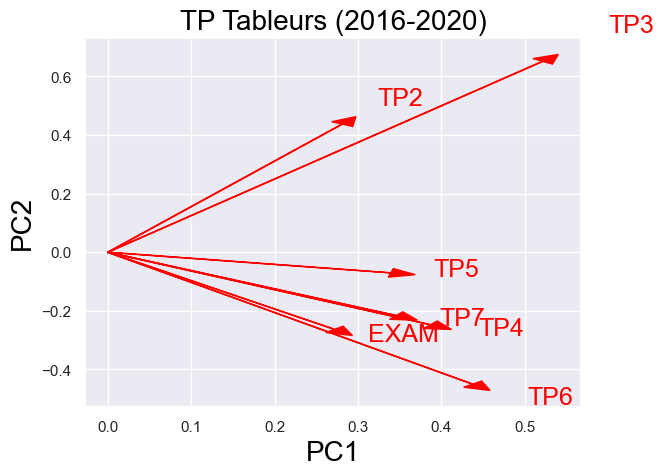

In [29]:
sns.set_theme()
fig, ax = plt.subplots()
for i, feature in enumerate(varsnames):
    ax.arrow(
        0, 0, ldngs[0, i], ldngs[1, i], head_width=0.03, head_length=0.03, color="red"
    )
    ax.text(ldngs[0, i] * 1.15, ldngs[1, i] * 1.15, feature, color="red", fontsize=18)
ax.set_xlabel("PC1", fontsize=20, color="black")
ax.set_ylabel("PC2", fontsize=20, color="black")
ax.set_title("TP Tableurs (2016-2020)", fontsize=20, color="black")
plt.show()

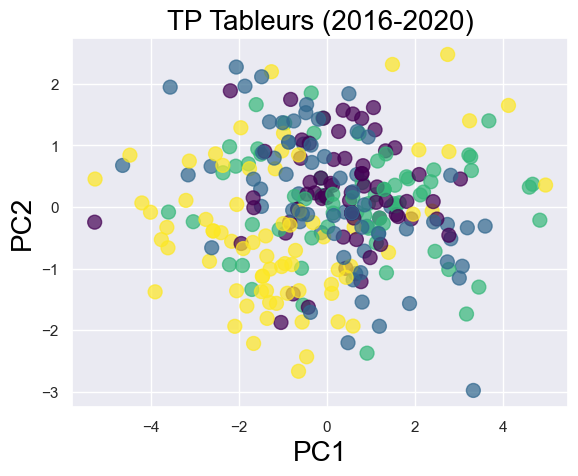

In [30]:
sns.set_theme()
fig, ax = plt.subplots()
scatter = ax.scatter(
    PC1, PC2, c=df['CATEGS'], cmap='viridis', s=100, alpha=0.7
)
ax.set_xlabel("PC1", fontsize=20, color="black")
ax.set_ylabel("PC2", fontsize=20, color="black")
ax.set_title("TP Tableurs (2016-2020)", fontsize=20, color="black")
plt.show()

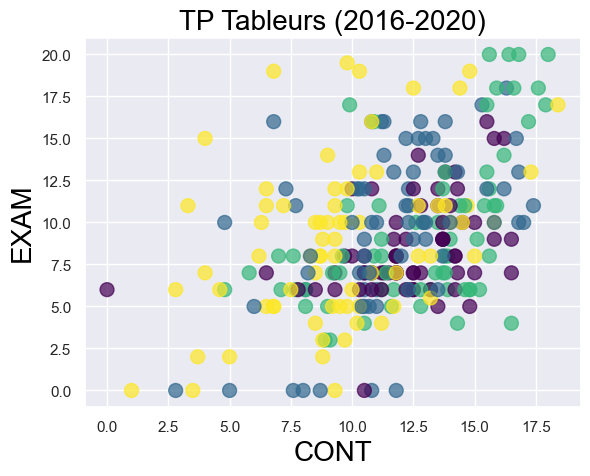

In [31]:
sns.set_theme()
fig, ax = plt.subplots()
scatter = ax.scatter(
    df['CONT'], df['EXAM0'], c=df['CATEGS'], cmap='viridis', s=100, alpha=0.7
)
ax.set_xlabel("CONT", fontsize=20, color="black")
ax.set_ylabel("EXAM", fontsize=20, color="black")
ax.set_title("TP Tableurs (2016-2020)", fontsize=20, color="black")
plt.show()

In [38]:
scaled_X = df[['PC1', 'PC2']].values
kmeans_kwargs = {
    "init": "random",
    "n_init": 20,
    "max_iter": 400,
    "random_state": 42,
}

d:\miniconda3\envs\infoenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\miniconda3\envs\infoenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\miniconda3\envs\infoenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
d:\miniconda3\envs\infoenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak o

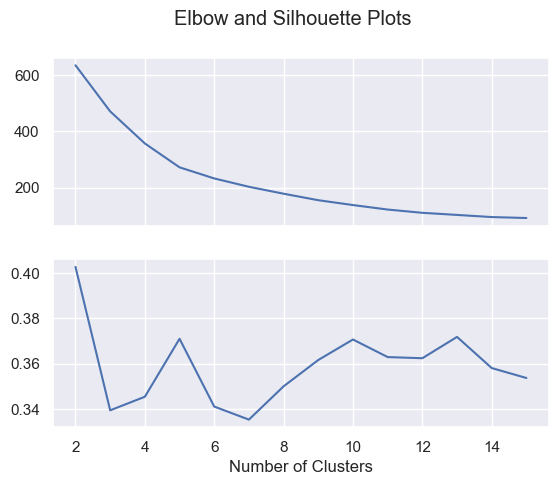

In [39]:
# A list holds the SSE values for each k
kstart = 2
kend = 16
krange = range(kstart, kend)
sse = []
for k in krange:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_X)
    sse.append(kmeans.inertia_)
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in krange:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_X)
    score = silhouette_score(scaled_X, kmeans.labels_)
    silhouette_coefficients.append(score)
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plt.xlabel("Number of Clusters")
ax1.plot(krange, sse)
ax2.plot(krange, silhouette_coefficients)
f.suptitle("Elbow and Silhouette Plots")
plt.show()